# Импорт

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchsummary

In [2]:
f_name = 'Camera 3_20220526_003249.mp4'
img_shape = (119,119)
xmin,ymin = 115, 210
xmax, ymax = 350, 445

# Собираем кадры из видео

In [3]:
if not os.path.isdir('data'):
    count = 0
    os.mkdir('data')
    cap = cv2.VideoCapture(f_name)

    while cap.isOpened():
        ret, frame = cap.read()

        if ret:
            frame = frame[ymin:ymax, xmin:xmax]
            frame = cv2.resize(frame, img_shape)
            cv2.imwrite(f'data/frame{count}.jpg', frame)
            count += 15 
            cap.set(cv2.CAP_PROP_POS_FRAMES, count)
        else:
            cap.release()
            break
else:
    print('Директория с данными уже существует')

Директория с данными уже существует


In [4]:
with_worker_size = len(os.listdir('data/with_worker'))
without_worker_size = len(os.listdir('data/without_worker'))
print(f'Количество кадров с работником {with_worker_size}')
print(f'Количество кадров без работника {without_worker_size}')

Количество кадров с работником 8785
Количество кадров без работника 28899


# Создаем датасеты

In [5]:
# Наблюдается дисбаланс по классам, поэтому возьмем только часть изображений, где работник отсутсвует
with_worker_paths = []
without_worker_paths = []

for name in os.listdir('data/with_worker'):
    with_worker_paths.append(f'data/with_worker/{name}')

for name in os.listdir('data/without_worker')[::5]:
    without_worker_paths.append(f'data/without_worker/{name}')
print(f'Количество кадров с работником {len(with_worker_paths)}')
print(f'Количество кадров без работника {len(without_worker_paths)}')

Количество кадров с работником 8785
Количество кадров без работника 5780


In [6]:
paths = with_worker_paths + without_worker_paths
labels = [1] * len(with_worker_paths) + [0] * len(without_worker_paths)
df = pd.DataFrame({'path':paths, 'label':labels})
df = df.sample(frac=1).reset_index(drop=True)
df

,path,label
0,data/with_worker/frame367920.jpg,1
1,data/without_worker/frame223920.jpg,0
2,data/without_worker/frame460905.jpg,0
3,data/without_worker/frame236775.jpg,0
4,data/without_worker/frame545970.jpg,0
...,...,...
14560,data/with_worker/frame312870.jpg,1
14561,data/with_worker/frame328395.jpg,1
14562,data/without_worker/frame222495.jpg,0
14563,data/with_worker/frame194265.jpg,1


In [7]:
train_df = df[:int(0.8 * df.shape[0])]
val_df = df[int(0.8 * df.shape[0]):int(0.9 * df.shape[0])]
test_df = df[int(0.9 * df.shape[0]):]
print(f'train size {train_df.shape[0]}')
print(f'val size {val_df.shape[0]}')
print(f'test size {test_df.shape[0]}')

train size 11652
val size 1456
test size 1457


In [8]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        label = torch.tensor([label]).float()
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(img / 255.0)
        img = img.permute(2,0,1)
        
        return img, label

In [9]:
train_ds = MyDataset(train_df['path'].values, train_df['label'].values)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = MyDataset(val_df['path'].values, val_df['label'].values)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=True)

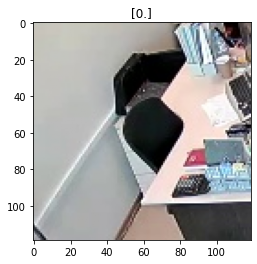

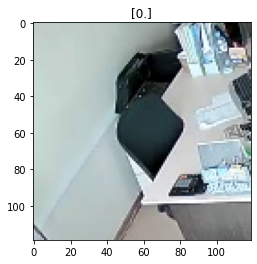

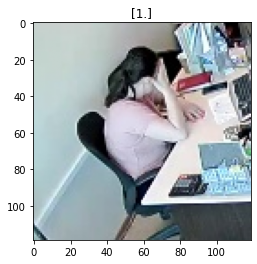

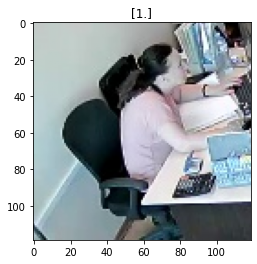

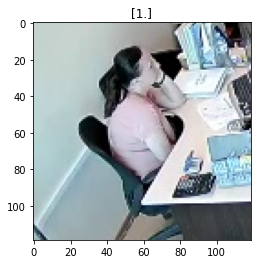

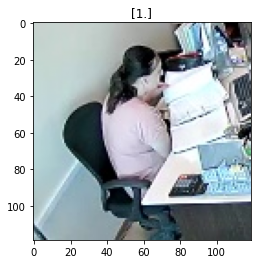

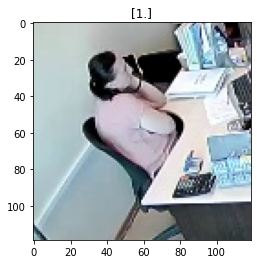

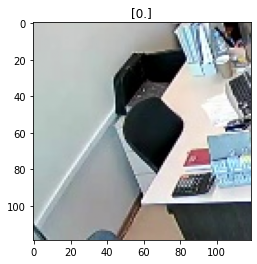

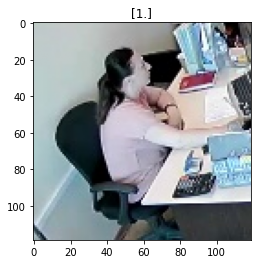

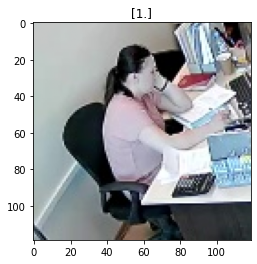

In [10]:
imgs, labels = next(iter(train_loader))
imgs = np.transpose(imgs, (0, 2, 3, 1))
for img, label in zip(imgs[:10], labels[:10]):
    plt.figure()
    plt.imshow(img)
    plt.title(str(label.detach().numpy()))

# Создаем и тренируем модель

In [11]:
model = nn.Sequential()

model.append(nn.Conv2d(3, 8, (3,3),2))
# model.append(nn.MaxPool2d((2,2)))

model.append(nn.Conv2d(8,16,(1,1)))
model.append(nn.Conv2d(16, 16, (3,1)))
model.append(nn.Conv2d(16, 16, (1,3)))
model.append(nn.ReLU())
model.append(nn.Conv2d(16, 16, (3,1),(2,1)))
model.append(nn.Conv2d(16, 16, (1,3),(1,2)))
model.append(nn.ReLU())

model.append(nn.Conv2d(16,32,(1,1)))
model.append(nn.Conv2d(32, 32, (3,1)))
model.append(nn.Conv2d(32, 32, (1,3)))
model.append(nn.ReLU())
model.append(nn.Conv2d(32, 32, (3,1),(2,1)))
model.append(nn.Conv2d(32, 32, (1,3),(1,2)))
model.append(nn.ReLU())

model.append(nn.Conv2d(32,32,(1,1)))
model.append(nn.Conv2d(32, 32, (3,1)))
model.append(nn.Conv2d(32, 32, (1,3)))
model.append(nn.ReLU())
model.append(nn.Conv2d(32, 32, (3,1),(2,1)))
model.append(nn.Conv2d(32, 32, (1,3),(1,2)))
model.append(nn.ReLU())



model.append(nn.Flatten())
model.append(nn.Linear(32*4*4, 1))
model.append(nn.Sigmoid())

torchsummary.summary(model, ((3,) + img_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 59, 59]             224
            Conv2d-2           [-1, 16, 59, 59]             144
            Conv2d-3           [-1, 16, 57, 59]             784
            Conv2d-4           [-1, 16, 57, 57]             784
              ReLU-5           [-1, 16, 57, 57]               0
            Conv2d-6           [-1, 16, 28, 57]             784
            Conv2d-7           [-1, 16, 28, 28]             784
              ReLU-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 32, 28, 28]             544
           Conv2d-10           [-1, 32, 26, 28]           3,104
           Conv2d-11           [-1, 32, 26, 26]           3,104
             ReLU-12           [-1, 32, 26, 26]               0
           Conv2d-13           [-1, 32, 12, 26]           3,104
           Conv2d-14           [-1, 32,

In [12]:
loss_func = nn.BCELoss()

from torch import optim
optimizer = optim.Adam(model.parameters(), lr = 0.001)  

from torch.autograd import Variable
num_epochs = 5
def train(num_epochs, model):
    
#     model.train()
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images.float())   # batch x
            b_y = Variable(labels)   # batch y
            output = model(images.float())               
            loss = loss_func(output, labels)
            
            optimizer.zero_grad()           
            
            loss.backward()    
            
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}],  Loss: {:.4f}' 
                       .format(epoch + 1,  num_epochs, loss.item()))

train(num_epochs, model)

Epoch [1/5],  Loss: 0.0699
Epoch [2/5],  Loss: 0.0162
Epoch [3/5],  Loss: 0.0065
Epoch [4/5],  Loss: 0.0084
Epoch [5/5],  Loss: 0.0000


In [13]:
torch.save(model, 'pytorch_model')

# Посмотрим на результаты на тестовом наборе данных

In [14]:
model = torch.load('pytorch_model')

In [15]:
test_ds = MyDataset(test_df['path'].values, test_df['label'].values)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

def visualize_predictions(img, label):
    plt.figure(figsize=(7,7))
    if label>0.5:
        title = 'Работник на месте'
    else:
        title = 'Работник отсутсвует'
    plt.imshow(img)
    plt.title(title)

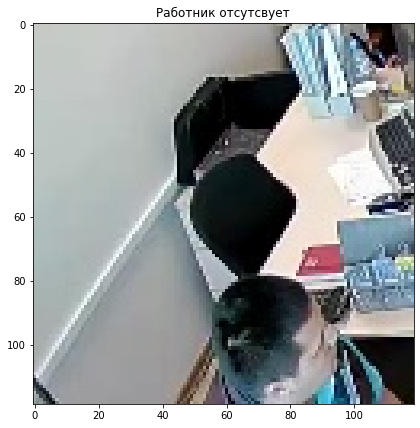

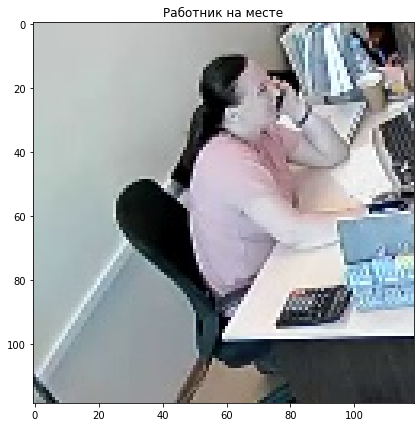

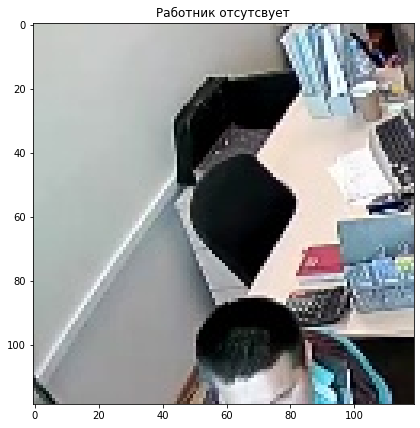

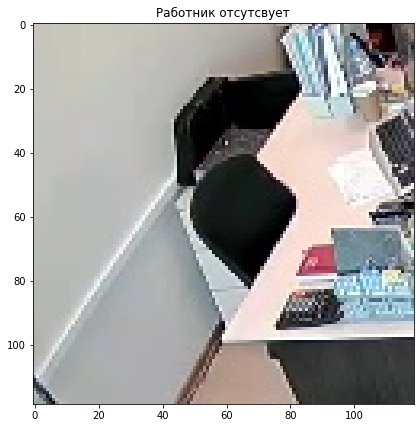

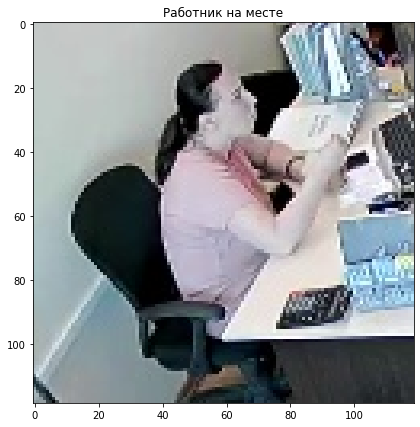

In [16]:
imgs, labels = next(iter(test_loader))

preds = model(imgs.float())
imgs = np.transpose(imgs, (0, 2, 3, 1))
for img, label in zip(imgs[:5], preds[:5]):
    visualize_predictions(img, label)